In [1]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import joblib

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import tarfile

tar_path = "/content/aclImdb_v1.tar.gz"
extract_path = "/content"
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)


In [3]:
import os
print(os.listdir("/content/aclImdb/train"))


['pos', 'urls_neg.txt', 'neg', 'unsup', 'labeledBow.feat', 'urls_unsup.txt', 'urls_pos.txt', 'unsupBow.feat']


In [4]:
def load_reviews_from_folder(folder_path, sentiment):
    reviews = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), encoding='utf-8') as file:
                text = file.read()
                reviews.append((text, sentiment))
    return reviews

base_path = "/content/aclImdb"
train_pos = load_reviews_from_folder(os.path.join(base_path, "train/pos"), 1)
train_neg = load_reviews_from_folder(os.path.join(base_path, "train/neg"), 0)
test_pos = load_reviews_from_folder(os.path.join(base_path, "test/pos"), 1)
test_neg = load_reviews_from_folder(os.path.join(base_path, "test/neg"), 0)

df = pd.DataFrame(train_pos + train_neg + test_pos + test_neg, columns=["review", "label"])
df.head()

,review,label
0,This is a movie that gets better each time I s...,1
1,one of the best low budget movies from Germany...,1
2,Rock 'n' Roll High School was one of the best ...,1
3,"The extended nuclear family, united in busines...",1
4,"Wow, I forgot how great this movie was until I...",1


In [5]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    return ' '.join([lemmatizer.lemmatize(word) for word in text if len(word) > 2])

df['clean_review'] = df['review'].apply(clean_text)

In [8]:
tfidf_pos = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')
tfidf_neg = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')

X_pos = tfidf_pos.fit_transform(df[df['label'] == 1]['clean_review'])
X_neg = tfidf_neg.fit_transform(df[df['label'] == 0]['clean_review'])


In [9]:
# I combined vocab from both models
pos_vocab = tfidf_pos.vocabulary_
neg_vocab = tfidf_neg.vocabulary_

sum_pos = X_pos.sum(axis=0).A1
sum_neg = X_neg.sum(axis=0).A1

all_terms = list(set(pos_vocab.keys()).union(set(neg_vocab.keys())))
pos_scores = {term: sum_pos[pos_vocab[term]] if term in pos_vocab else 0 for term in all_terms}
neg_scores = {term: sum_neg[neg_vocab[term]] if term in neg_vocab else 0 for term in all_terms}

diff_scores = {term: pos_scores[term] - neg_scores[term] for term in all_terms}

# Sort
top_pos_ngrams = sorted(diff_scores.items(), key=lambda x: x[1], reverse=True)[:30]
top_neg_ngrams = sorted(diff_scores.items(), key=lambda x: x[1])[:30]

print(" Top Positive Discriminative N-grams:", [w for w, _ in top_pos_ngrams])
print(" Top Negative Discriminative N-grams:", [w for w, _ in top_neg_ngrams])


 Top Positive Discriminative N-grams: ['great', 'love', 'best', 'excellent', 'wonderful', 'life', 'loved', 'performance', 'favorite', 'perfect', 'amazing', 'beautiful', 'film', 'brilliant', 'family', 'series', 'world', 'war', 'enjoyed', 'today', 'superb', 'highly', 'episode', 'fun', 'fantastic', 'year', 'story', 'young', 'heart', 'definitely']
 Top Negative Discriminative N-grams: ['bad', 'worst', 'movie', 'wa', 'waste', 'awful', 'terrible', 'just', 'boring', 'stupid', 'minute', 'horrible', 'worse', 'plot', 'waste time', 'poor', 'acting', 'script', 'worst movie', 'money', 'crap', 'don', 'supposed', 'like', 'bad movie', 'avoid', 'guy', 'poorly', 'didn', 'look like']


In [10]:
def wordcloud_from_ngrams(top_ngrams, title):
    text = {w: s for w, s in top_ngrams}
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()



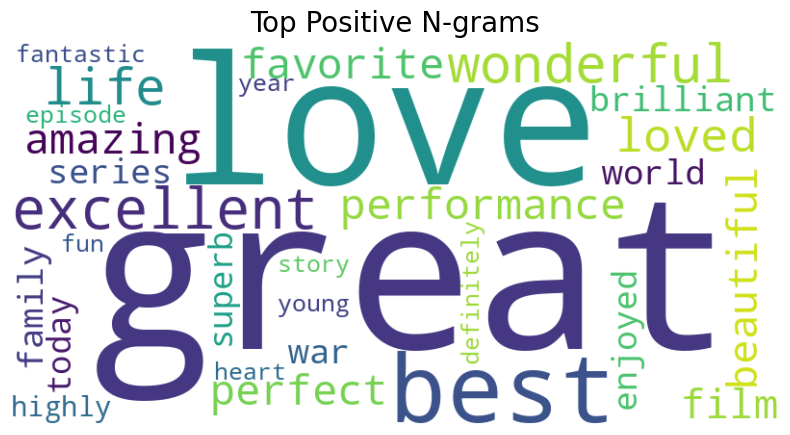

In [11]:
wordcloud_from_ngrams(top_pos_ngrams, "Top Positive N-grams")


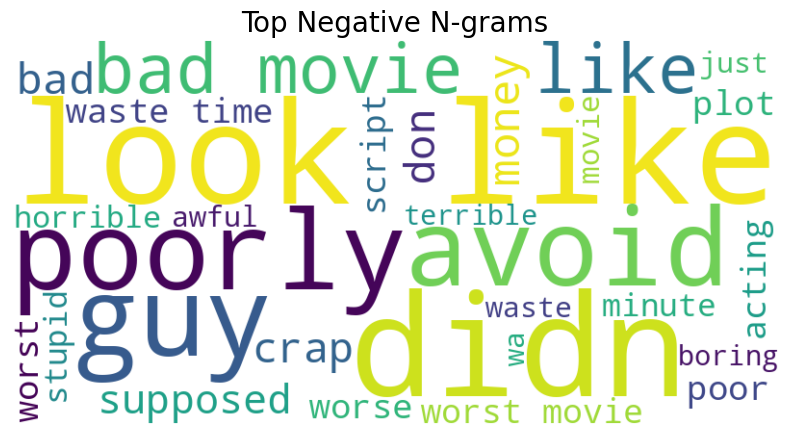

In [12]:
wordcloud_from_ngrams(top_neg_ngrams, "Top Negative N-grams")

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['clean_review']).toarray()
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Logistic Regression:\n", classification_report(y_test, lr.predict(X_test)))

nb = MultinomialNB()
nb.fit(X_train, y_train)
print("Naive Bayes:\n", classification_report(y_test, nb.predict(X_test)))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      4945
           1       0.88      0.90      0.89      5055

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Naive Bayes:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4945
           1       0.85      0.87      0.86      5055

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

